# Stephen Cohen

## Sommaire :

- ### TP : Dataset 1
- ### Dataset 2
- ### Dataset 3
- ### Conclusion 

# TP : Decision trees and ensemble methods

In the first part, you are asked to implement a **Stump**, i.e. a decision tree of depth 1, from scratch. Our tree should be able to handle weighted and unweighted samples, in order for it to be used as a weak learner for
**AdaBoost** in the second part.

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_moons, make_circles, make_classification

The following code creates 3 synthetic datasets, in which there are just two features, for binary classification. We ask you to provide the solutions to the exercises on all elements of the list ```datasets```.

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2886069118.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[fi].scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.RdYlBu, edgecolor='black', s=100)


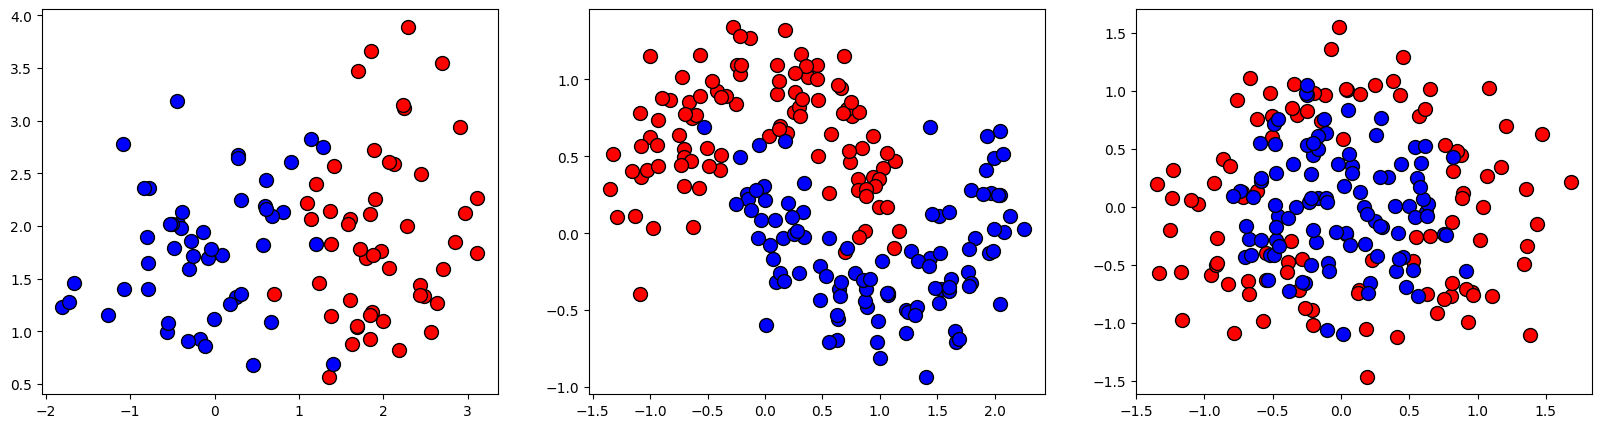

In [81]:
plot_colors = "rb"
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [linearly_separable,
            make_moons(n_samples = 200, noise=0.2, random_state=0),
            make_circles(n_samples = 200, noise=0.3, factor=0.5, random_state=1)
            ]

fig, ax = plt.subplots(1, 3, figsize=(20,5))
for fi in range(len(datasets)):
    dataset = datasets[fi]
    X = dataset[0]
    y = dataset[1]
    n_classes = len(np.unique(y))
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        ax[fi].scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.RdYlBu, edgecolor='black', s=100)
dataset = datasets[1]

In [82]:
def plot_tree(clf, X, y):
    n_classes = 2
    plot_colors = "rb"
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("tight")
    # Plot the training points
    for i, color in zip([-1,1], plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)
    plt.show()

## First part: Stumps

In this first part, you will code your own class to handle stumps for 2-dimensional data and binary classification (i.e., the class takes value in $\{0, 1\}$). You can find the outline of the code you will need to write, following these instructions:
- Implement the ```fit``` method : since the weak learners are potentially executed a large number of times, efficiency is crucial. Use the incremental evaluation of the partitions seen in class : the complexity should be  $O(ndc)$ instead of the naive $O(n^2 dc)$ version. We assume that the sorting operations such as ```argsort``` are free because we only need to run them once. Iterate in the 2-dimensions for every possible split, evaluate the quality of each split using an incremental version of the Gini index (defined next) and store the best split. (Note : a non-incremental version will be graded with half the points)
- Implement the ```gini``` method : Implement the Gini index coefficient for the case in which there are only 2 classes. In class, you saw the unweighted case: we quickly recall the unweighted then weighted version. Let $C$ be the number of different classes, $p_k(S)$ be the ratio of datapoints of class $k$ in region $S$. Then, the Gini index $G(S)$ is $$ G(S) = 1 - \sum_{k=1}^{C} p_k(S)^2$$ Given a split in which we have left and right regions $S_r$, $S_l$, let $N_r$ (resp. $N_l$) be the number of datapoints in $S_r$ (resp. $S_l$). The Gini index of the split is the combination of the Gini index of both regions: $$ \frac{N_r}{N_r + N_l}G(S_r) + \frac{N_l}{N_r + N_l}G(S_l) $$ For generalizing to the weighted case, let $w_k(S)$ be the sum of the weights of all data-points of class $k$ in $S$. The Gini index is defined as follows: $$ G(S) = 1 - \sum_{k=1}^{C} \left( \frac{w_k(S)}{  \sum_{m=1}^{C} w_m(S)} \right)^2 $$ Given a split in which we have left and right regions $S_r$, $S_l$, let $W_r = \sum_{k=1}^{C} w_k(S)$ (resp. $W_l$) the total weight on $S_r$ (resp. $S_l$). The Gini index of the partition is the combination of the Gini index of both regions: $$ \frac{W_r}{W_r + W_l}G(S_r) + \frac{W_l}{W_r + W_l}G(S_l) $$
- Implement the ```predict``` method. The input is an array of $n$ $d$-dimensional observations. The output is a ```np.array``` of length $n$. Once the ```predict``` method is coded, use the given function ```plot_tree(my_stump, X, y)``` to plot ```my_stump``` on each of the ```datasets```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [83]:
import numpy as np

class My_stump:
    def __init__(self):
        self.best_dimension = None
        self.best_threshold = None
        self.class_below_threshold = None
        self.class_above_threshold = None
        self.best_ev = float('inf')  # Initialiser à l'infini pour trouver la valeur minimale
        
    def get_threshold(self):
        return self.best_threshold
  
    def get_best(self):
        return self.best_dimension,  self.best_threshold, self.best_ev
    
    def gini(self, weights):
        total_weight = np.sum(weights)
        if total_weight == 0:
            return 0
        proportions = weights / total_weight
        return 1 - np.sum(proportions ** 2)

    def fit(self, X, y, sample_weight=None):
        n_samples, n_features = X.shape
        if sample_weight is None:
            sample_weight = np.ones(n_samples)
        
        for feature in range(n_features):
            thresholds, classes = zip(*sorted(zip(X[:, feature], y)))
            weights = sample_weight[np.argsort(X[:, feature])]
            
            left_count = np.zeros(2)
            right_count = np.bincount((y + 1) // 2, weights=sample_weight, minlength=2)
            
            for i in range(1, n_samples):
                c = (classes[i-1] + 1) // 2
                left_count[c] += weights[i-1]
                right_count[c] -= weights[i-1]
                
                if thresholds[i] == thresholds[i-1]:
                    continue
                
                gini_left = self.gini(left_count)
                gini_right = self.gini(right_count)
                
                w_left = np.sum(left_count)
                w_right = np.sum(right_count)
                gini_split = (w_left * gini_left + w_right * gini_right) / (w_left + w_right)
                
                if gini_split < self.best_ev:
                    self.best_ev = gini_split
                    self.best_dimension = feature
                    self.best_threshold = (thresholds[i] + thresholds[i-1]) / 2
                    self.class_below_threshold = np.argmax(left_count) * 2 - 1
                    self.class_above_threshold = np.argmax(right_count) * 2 - 1

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples, dtype=int)
        for i in range(n_samples):
            if X[i, self.best_dimension] < self.best_threshold:
                predictions[i] = self.class_below_threshold
            else:
                predictions[i] = self.class_above_threshold
        return predictions


- Using ```DecisionTreeClassifier``` in ```sklearn```, fit a stump on the data.

In [84]:
dataset = datasets[1]
X = dataset[0]
y = dataset[1]*2-1 
w = np.ones(len(X)) 



my_stump = My_stump()
my_stump.fit(X, y, w)
my_stump.predict(X)

array([-1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1,
        1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1, -1,
       -1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1, -1,
        1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1,
       -1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1,
       -1,  1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,
       -1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1,
        1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,
        1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,  1,  1, -1,
       -1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1, -1, -1, -1,
        1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1])

- Check the correctness of your code: With ```tree.plot_tree(sk_stump)``` compare the dimension of the split, the threshold and the Gini indices obtained through your own code and those of ```sk_stump```.

Difference in the best threshold: -2.9161397741006567e-09


C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


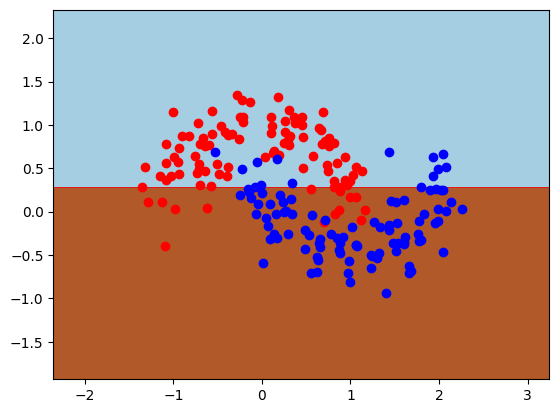

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


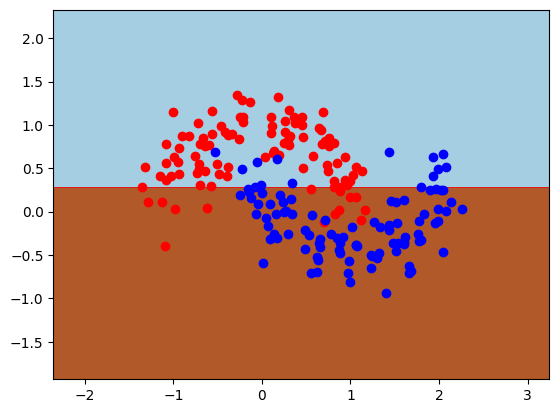

In [85]:
# Check your code
sk_stump = tree.DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=w)
my_stump = My_stump()
my_stump.fit(X, y, w)

print("Difference in the best threshold:", sk_stump.tree_.threshold[0] -  my_stump.get_threshold())

plot_tree(my_stump,X,y)
plot_tree(sk_stump,X,y)

## Second part: Adaboost

Implement the **AdaBoost** seen in class. You can use the ```my_stump``` implemented before. We encourage you to check the correctness by comparing it to ```sk_stump```.
- Implement the ```fit``` function in the provided template using the utility functions.

<div class='alert alert-block alert-info'>
            Code:</div>

In [100]:
import pandas as pd

# Compute the error rate of a weak classifier with weights w_m
def compute_error(y, y_pred, w_m):
    indices = y != y_pred
    return np.sum(w_m[indices])

# Compute alpha 
def compute_alpha(error):
    return np.log((1-error)/error)/2

# Compute the update of the weights
def update_weights(w_i, alpha, y, y_pred):
    return w_i * np.exp(-alpha*y*y_pred)/np.sum(w_i)


class AdaBoost:
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.loss_ensemble = []
        
    def predict(self, X):
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 
        for m in range(len(self.G_M)):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)
        return y_pred.values

    def fit(self, X, y, M=10):
        self.alphas = []
        self.training_errors = []
        self.M = M
        self.G_M = []  
        Z = 1

        for m in range(M):  
            if m == 0:
                w_m = np.ones(len(y)) * 1 / len(y)
            else:
                w_m = update_weights(w_m, alpha_m, y, y_pred)
            G_m = My_stump()
            G_m.fit(X, y, sample_weight=w_m)
            y_pred = G_m.predict(X)
            error_m = compute_error(y, y_pred, w_m)
            if error_m > 0.5:
                continue
            alpha_m = 0.5 * np.log((1 - error_m) / error_m)
            w_m = update_weights(w_m, alpha_m, y, y_pred)
            self.G_M.append(G_m)
            self.alphas.append(alpha_m)
            
            # Compute and store the ensemble loss (Z)
            Z *= 2 * np.sqrt(error_m * (1 - error_m))
            self.loss_ensemble.append(Z)
            
            
            
            plot_tree(self, X, y)


- Run the code for 20 iterations. At each iteration, plot the result of the ensemble of AdaBoost ```ab``` using ```plot_tree(ab, X, y)```
- Plot the evolution of the loss in the 20 iterations.

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


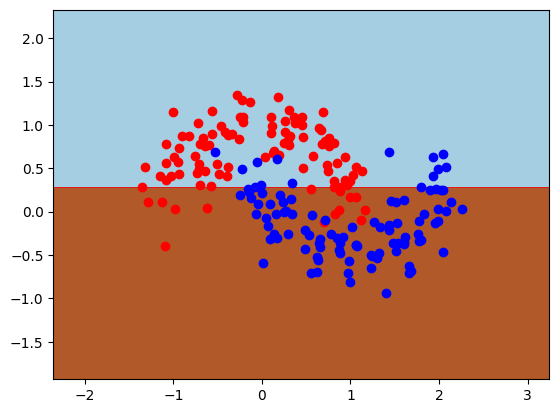

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


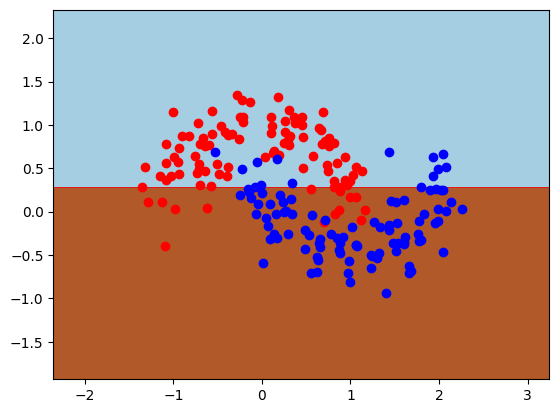

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


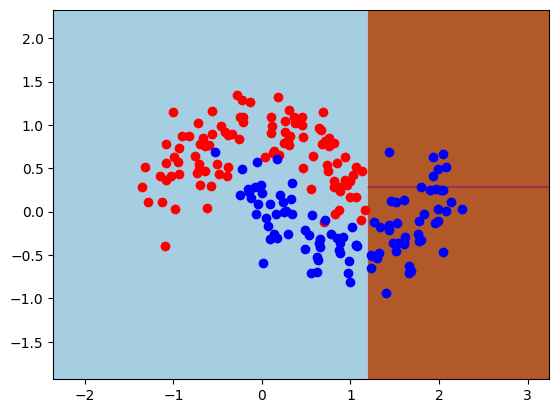

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


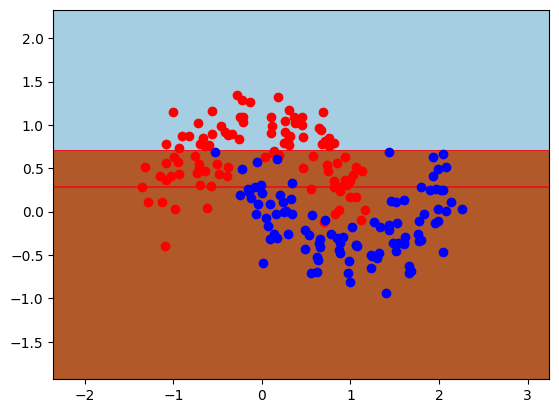

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


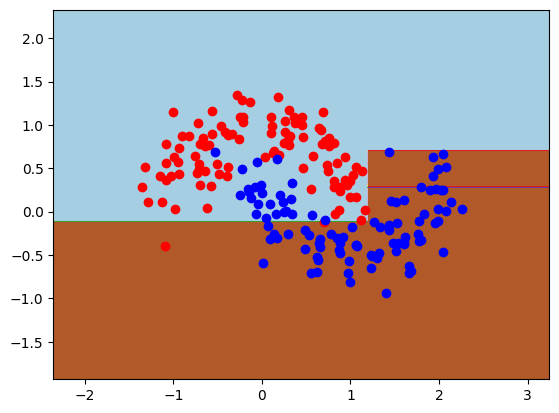

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


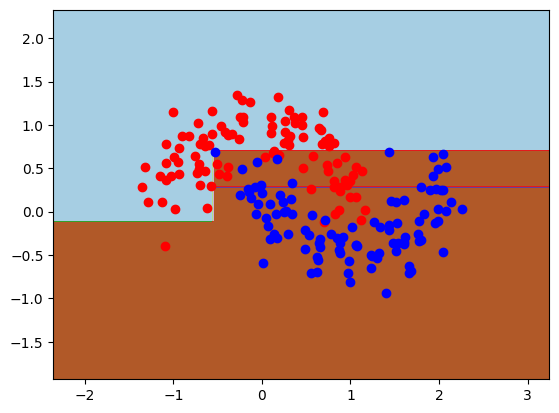

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


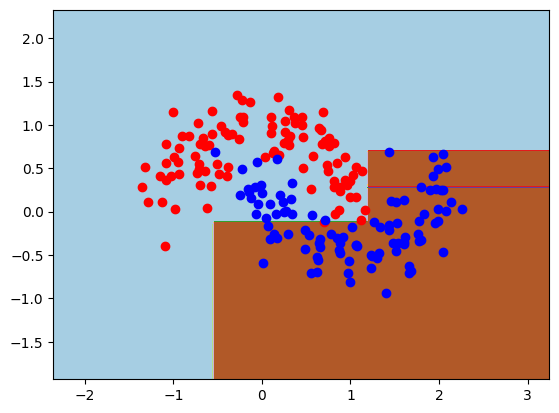

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


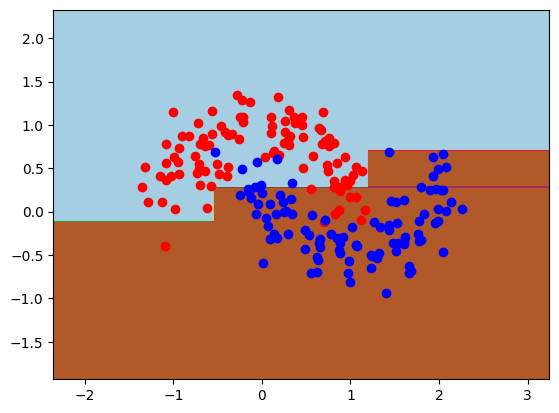

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


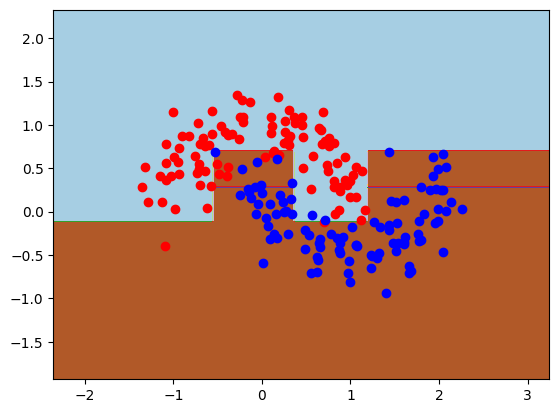

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


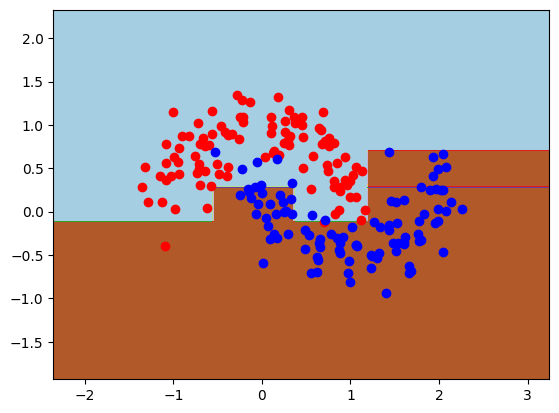

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


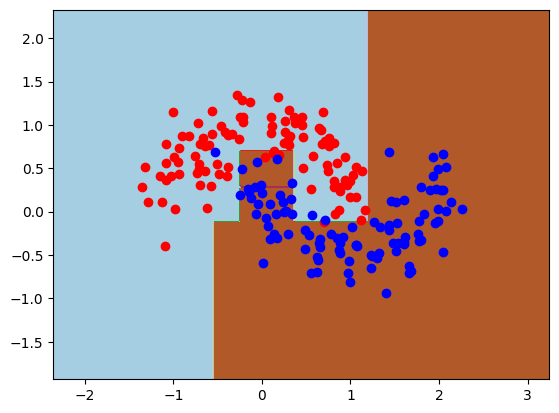

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


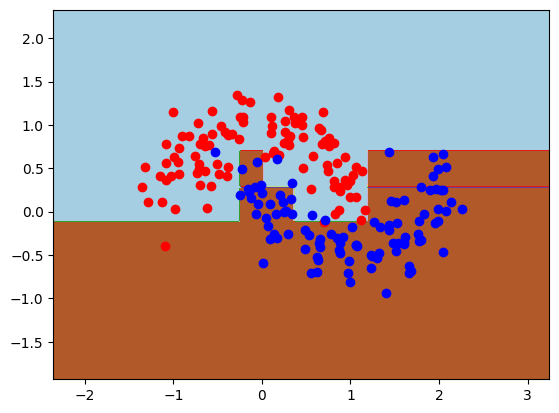

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


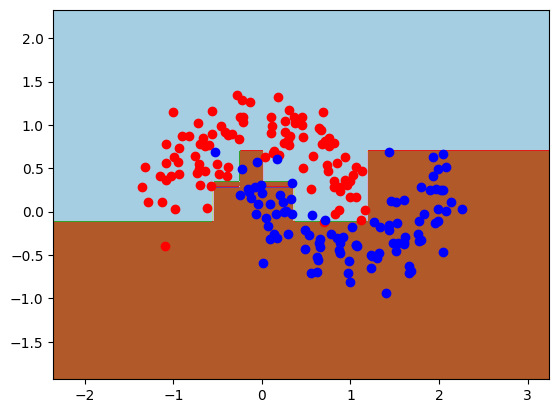

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


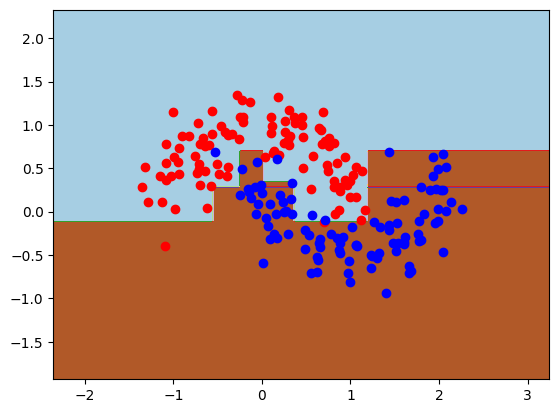

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


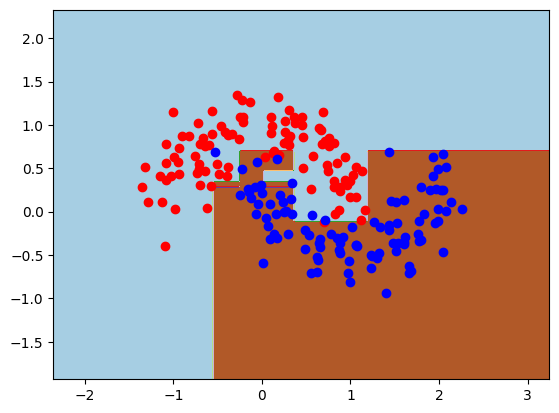

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


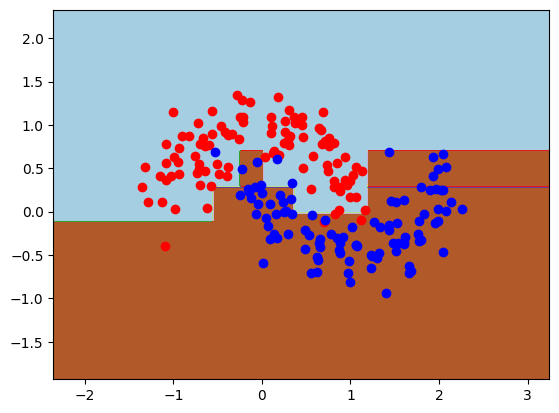

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


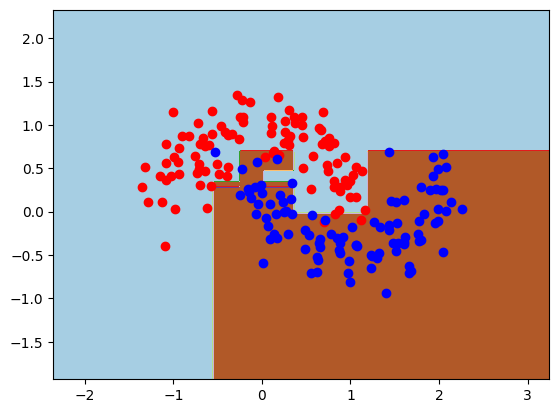

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


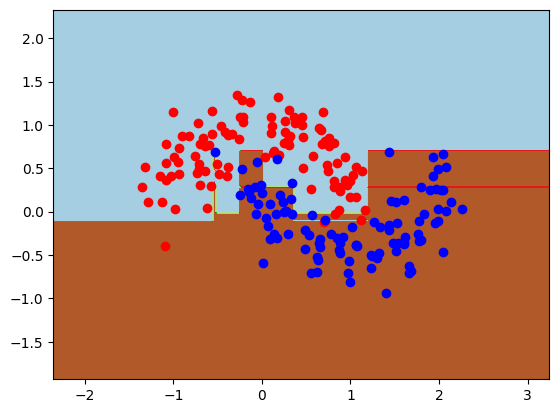

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


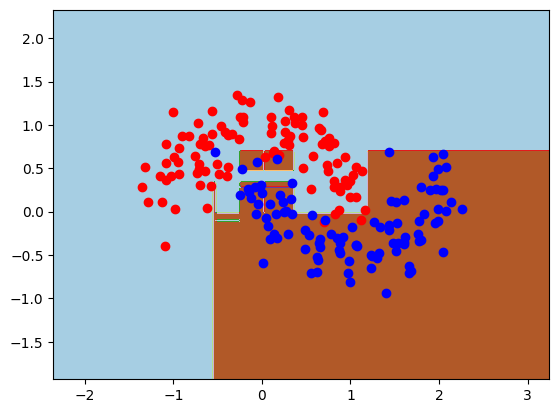

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


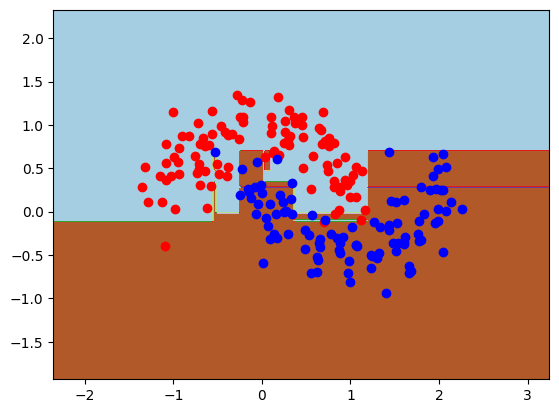

[0.6726068688320095, 0.5264860255799856, 0.4794191534663842, 0.3293790270201949, 0.23061801157786765, 0.16270805470827762, 0.11630805633399748, 0.09959194011564607, 0.08544758502612952, 0.06347504862099021, 0.0444192738504547, 0.03475939977053305, 0.02990239731638628, 0.02754627644706669, 0.02371582824350102, 0.01957262140063401, 0.017324818408913048, 0.014867694153974693, 0.012378995578119821, 0.011121750603469068]


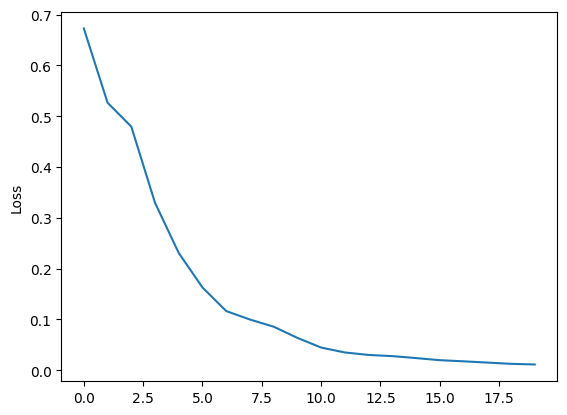

In [101]:
from sklearn.tree import DecisionTreeClassifier

ab = AdaBoost()


ab.fit(X, y, M = 20)
print(ab.loss_ensemble)
plt.plot(ab.loss_ensemble)
plt.ylabel("Loss")
plt.show()



## Data set 2 : 

Difference in the best threshold: -8.961004827057195e-09


C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


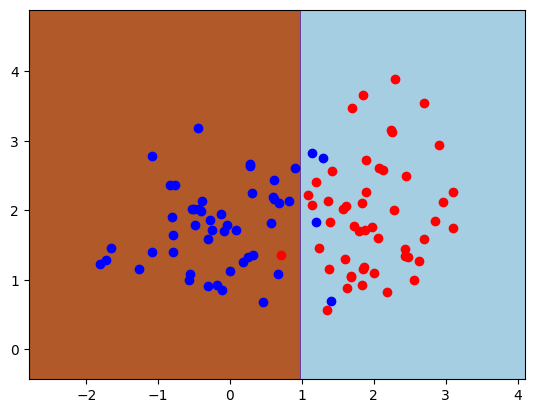

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


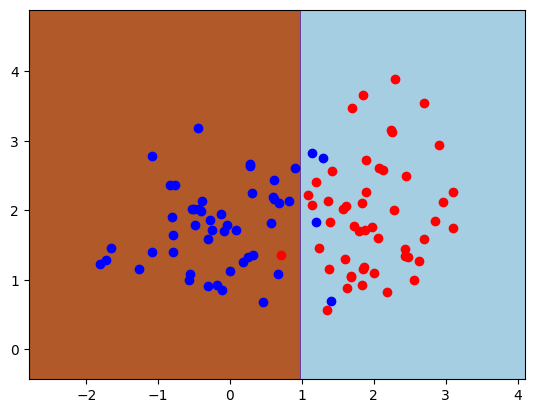

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


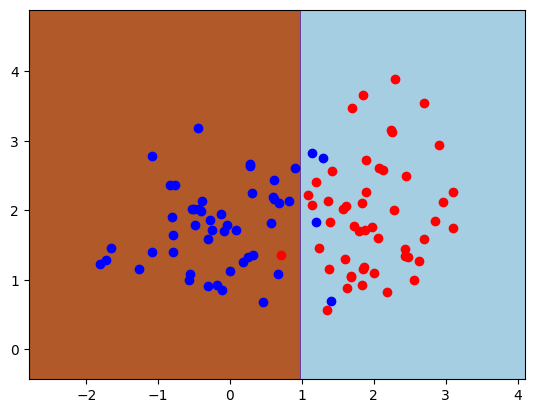

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


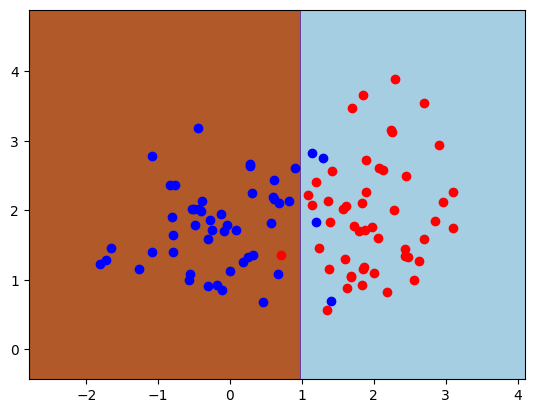

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


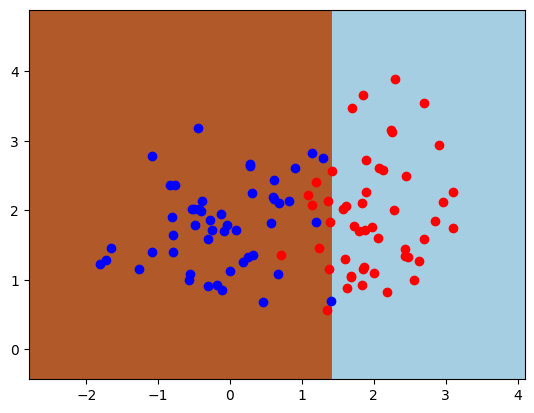

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


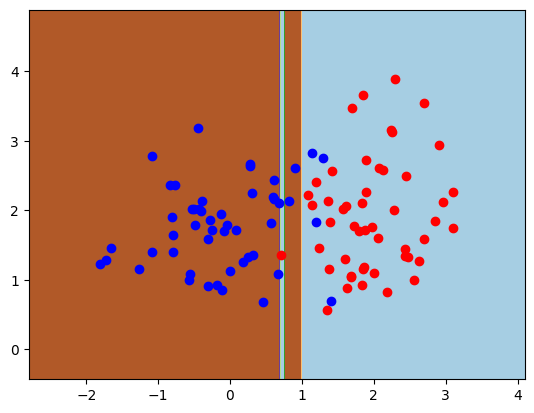

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


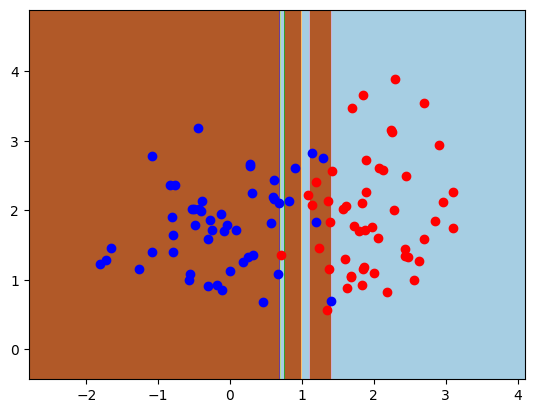

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


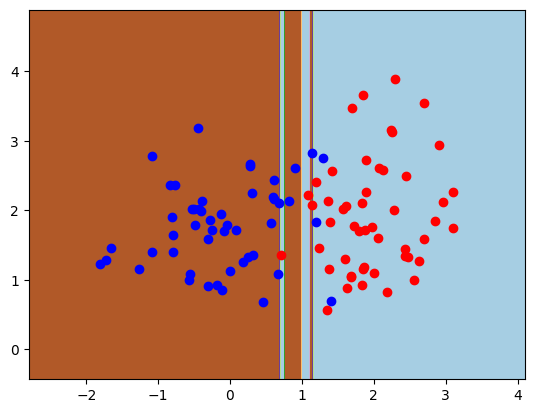

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


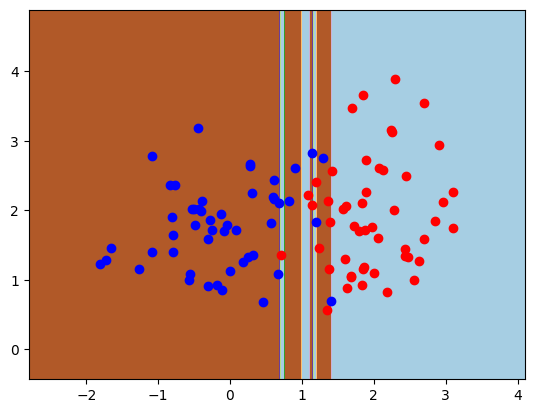

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


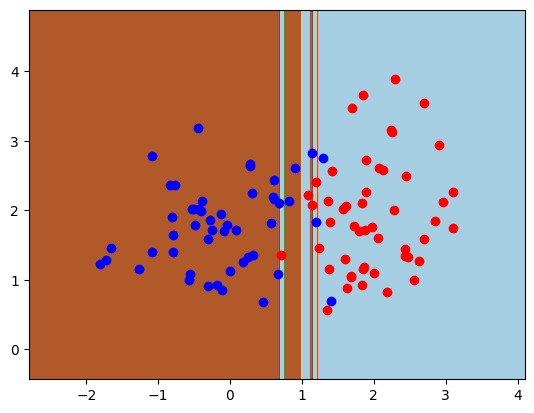

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


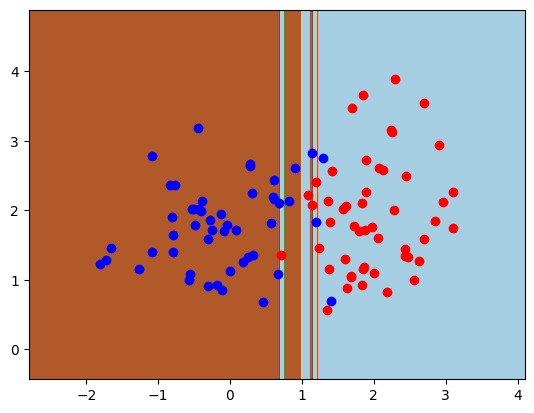

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


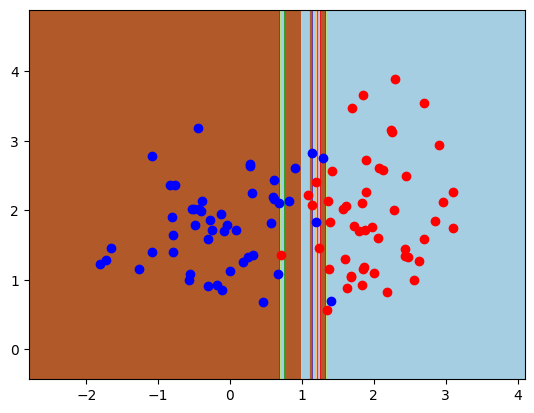

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


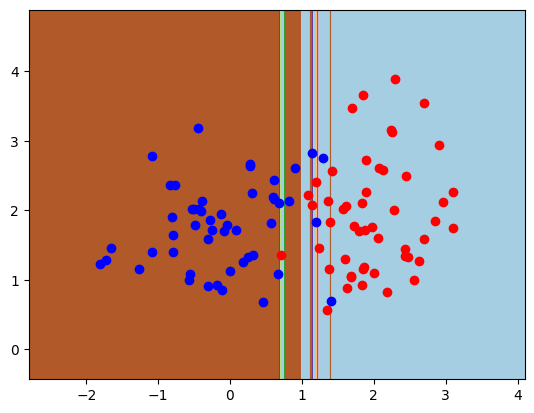

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


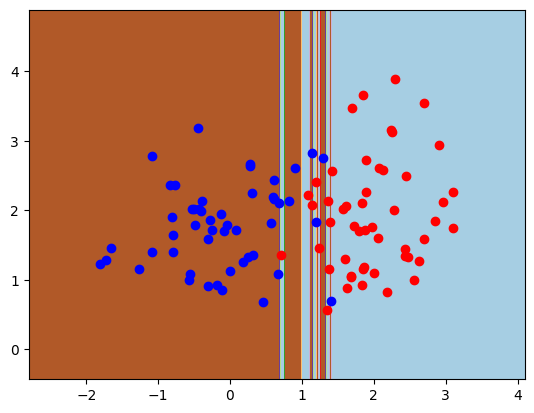

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


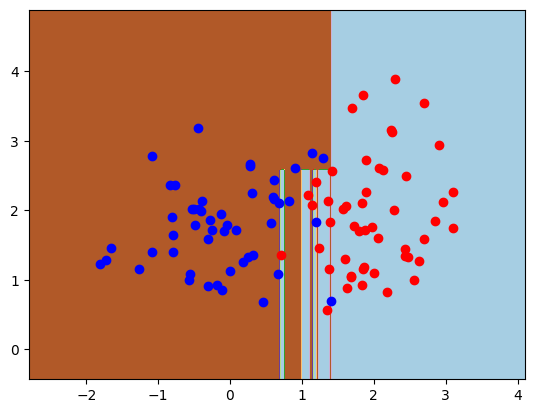

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


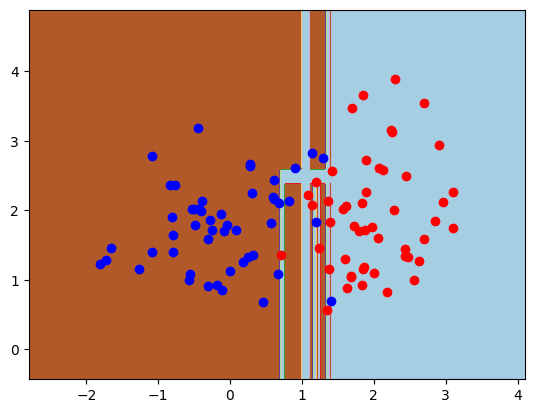

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


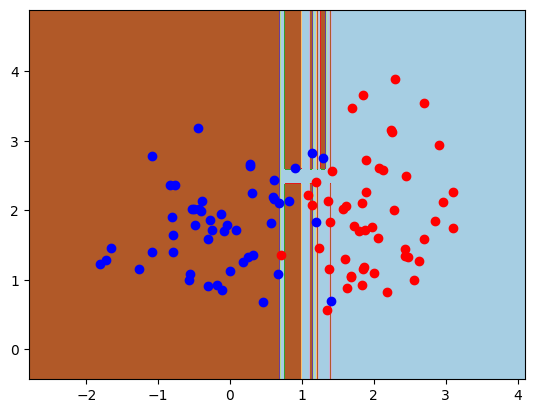

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


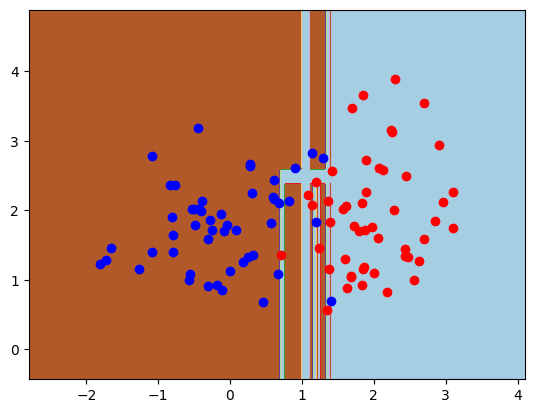

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


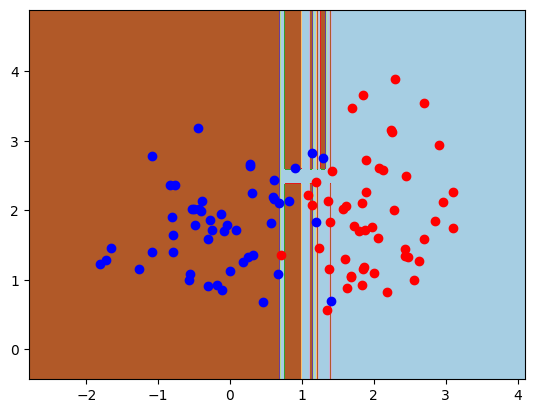

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


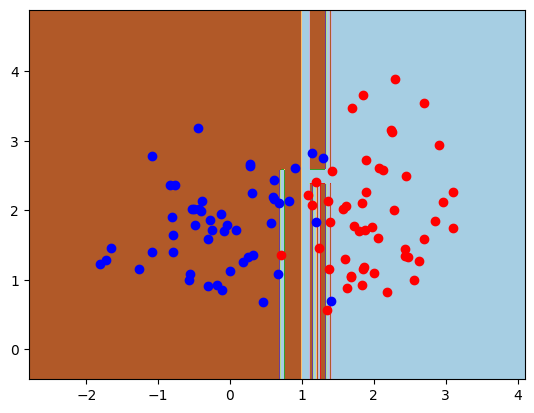

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


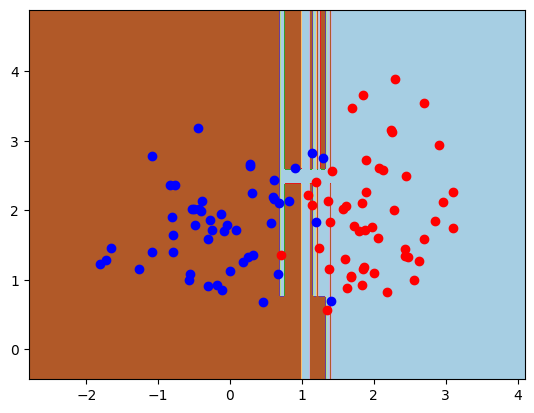

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


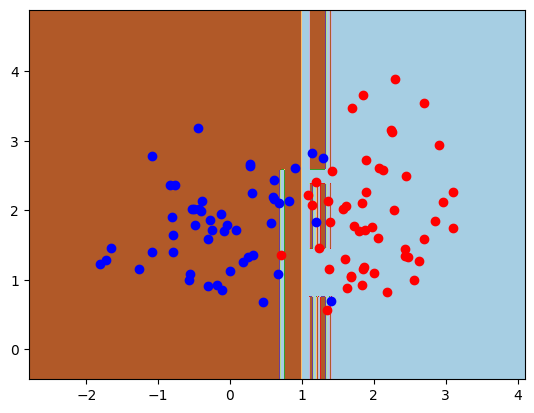

[0.43588989435406733, 0.2752440253637922, 0.17917725730724, 0.07107582679581302, 0.03682007353285159, 0.025839057967743627, 0.020151571964474292, 0.01579162085583169, 0.013323053270985633, 0.010146444638669785, 0.006690545173591992, 0.003462396645498037, 0.0018793540029817103, 0.0014105590116136905, 0.0011181003381209762, 0.0009370234096453765, 0.000807476123450483, 0.0006518058604373636, 0.0005370698500257348, 0.0003814436170884298]


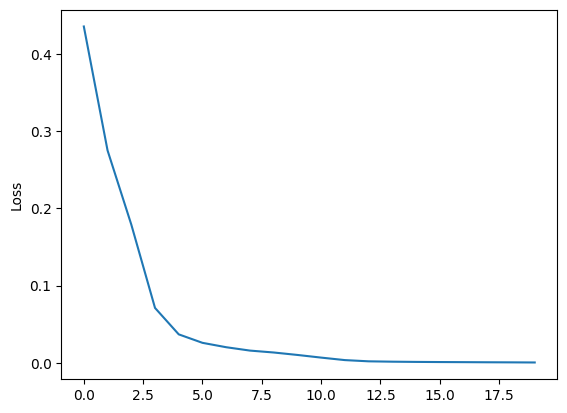

In [103]:
dataset = datasets[0]
X = dataset[0]
y = dataset[1]*2-1 
w = np.ones(len(X)) 



my_stump = My_stump()
my_stump.fit(X, y, w)
my_stump.predict(X)


sk_stump = tree.DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=w)
my_stump = My_stump()
my_stump.fit(X, y, w)

print("Difference in the best threshold:", sk_stump.tree_.threshold[0] -  my_stump.get_threshold())

plot_tree(my_stump,X,y)
plot_tree(sk_stump,X,y)

ab = AdaBoost()


ab.fit(X, y, M = 20)
print(ab.loss_ensemble)
plt.plot(ab.loss_ensemble)
plt.ylabel("Loss")
plt.show()


## Data set 3 : 

Difference in the best threshold: -1.7781981442865913e-08


C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


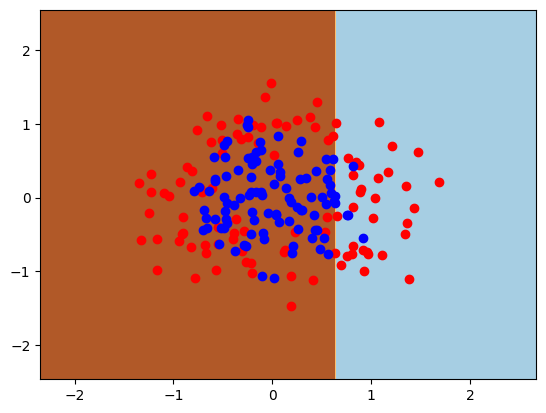

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


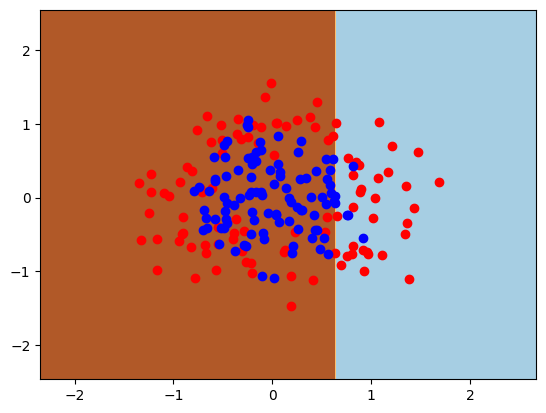

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


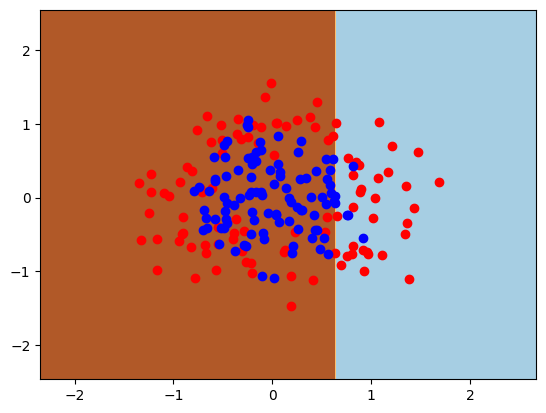

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


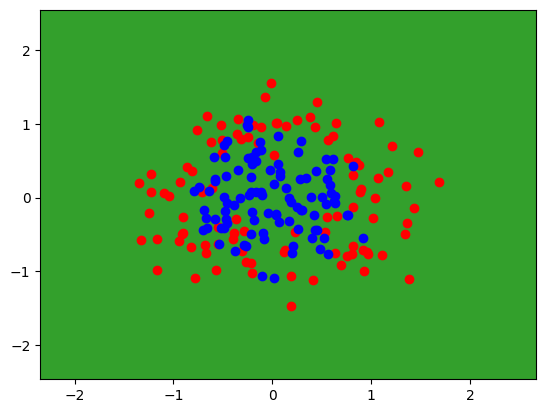

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


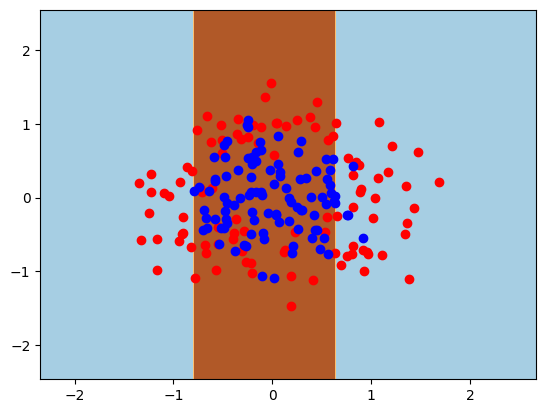

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


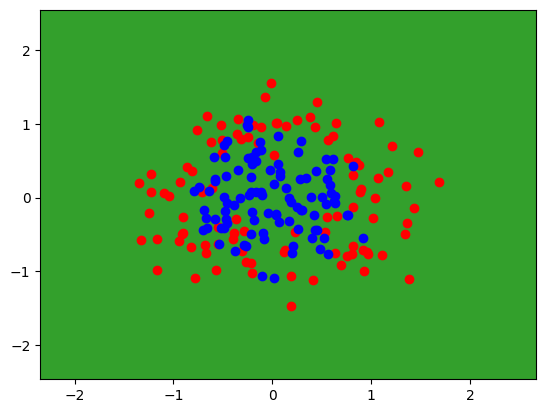

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


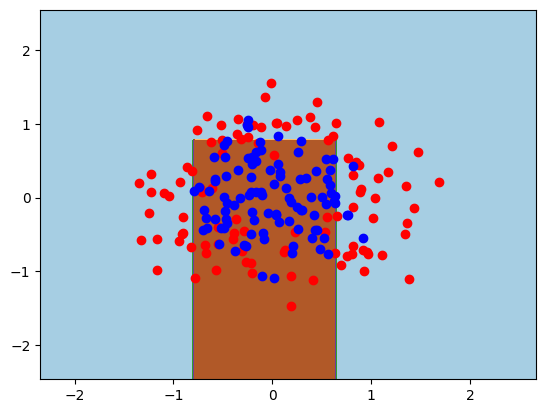

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


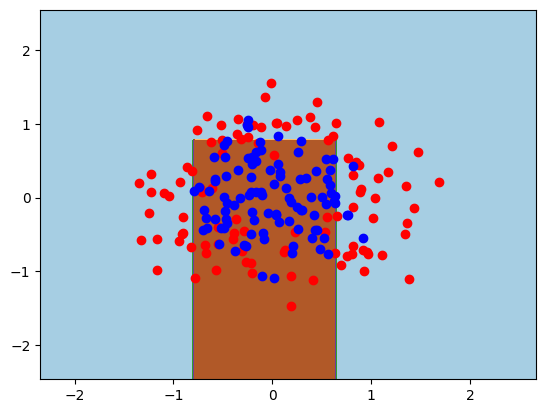

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


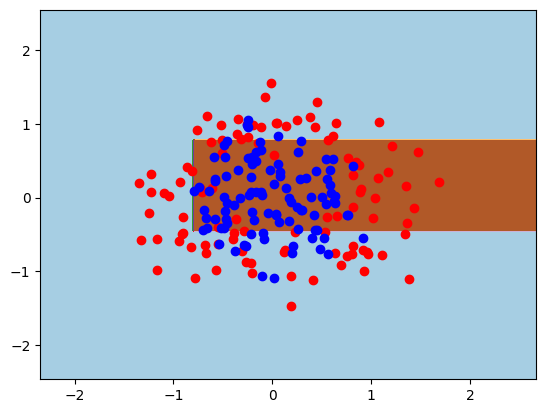

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


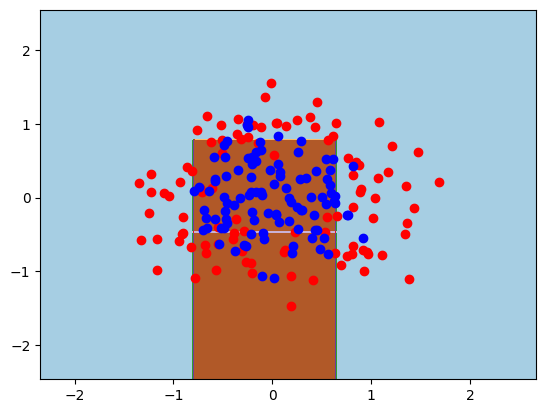

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


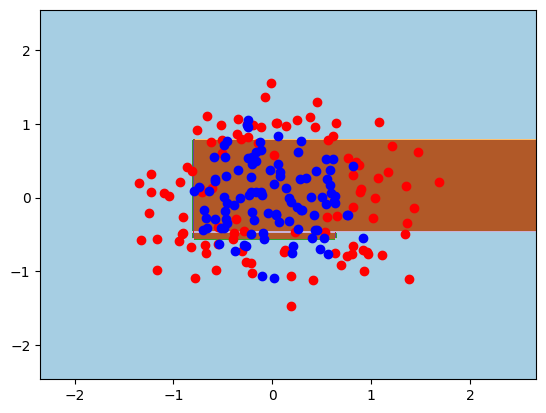

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


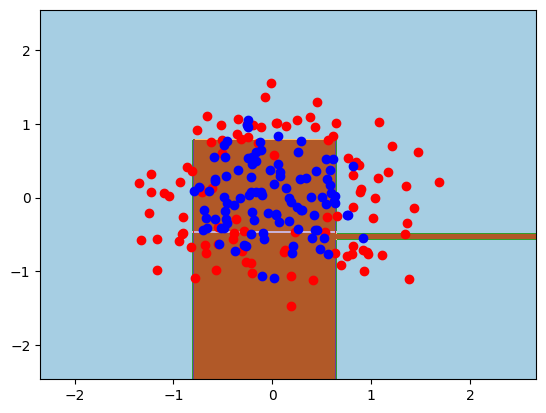

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


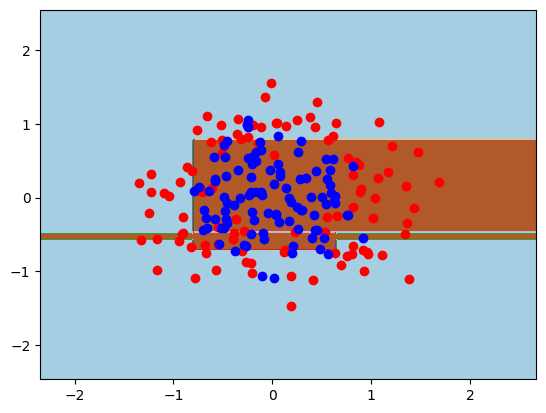

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


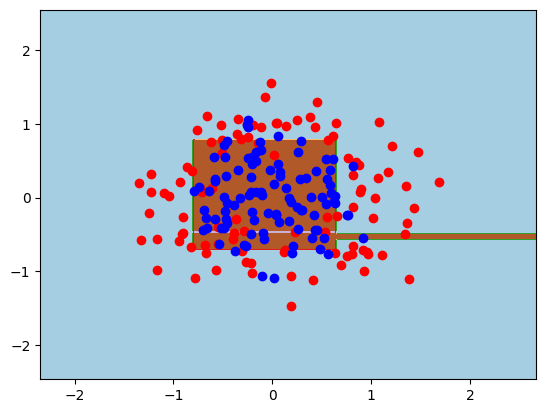

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


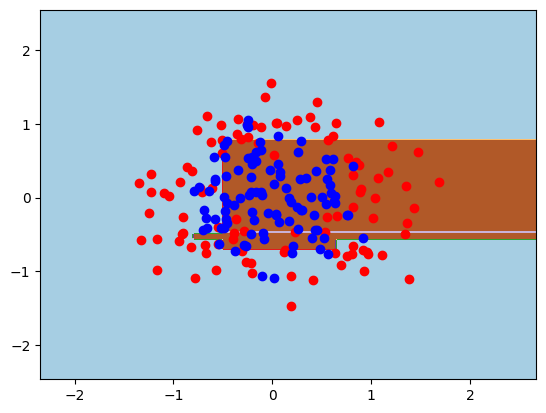

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


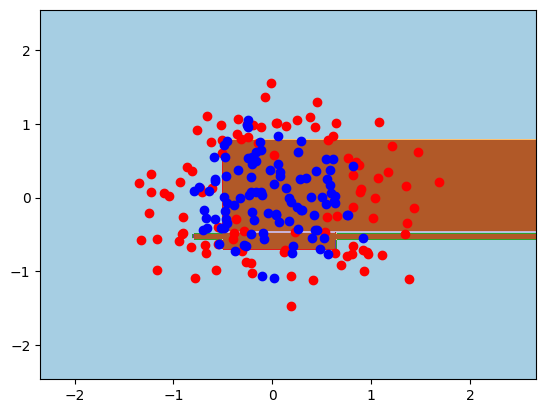

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


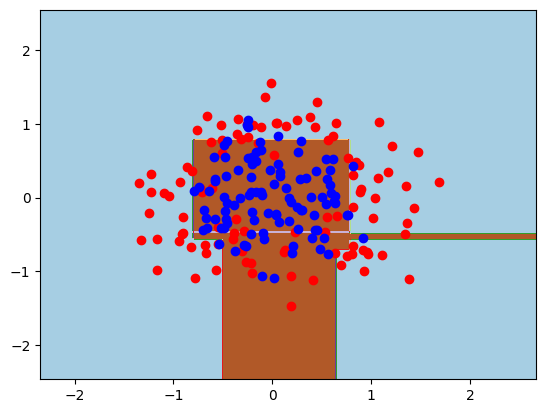

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


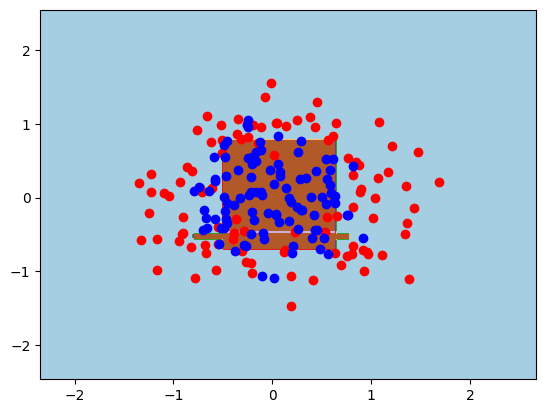

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


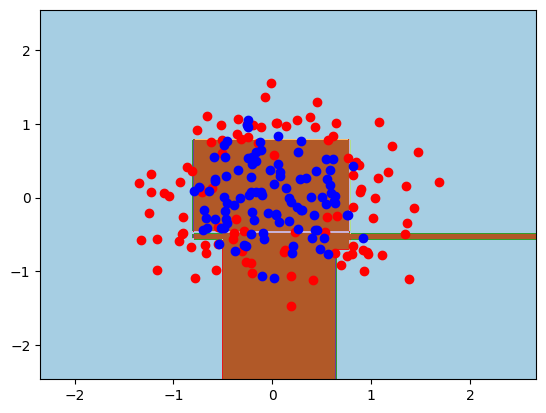

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


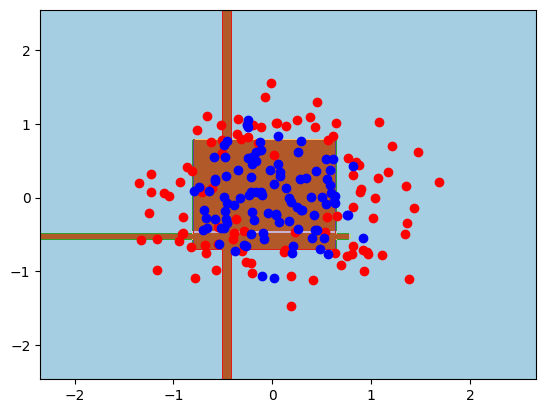

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


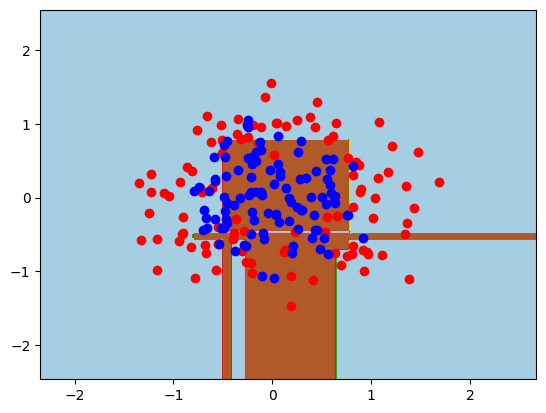

C:\Users\Stephen\AppData\Local\Temp\ipykernel_17992\2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


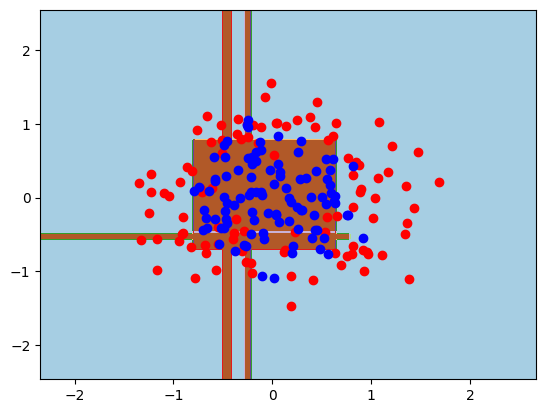

[0.9628603221651623, 0.9002804521836932, 0.8071935460644627, 0.7336144381860525, 0.6342423084372232, 0.6039083265414334, 0.5281886171861593, 0.4764461269439569, 0.436701520792554, 0.40882533274808436, 0.3908926090963562, 0.3778267488816238, 0.34421627637776975, 0.33691902241469346, 0.3063348778651674, 0.27520616047958785, 0.2591890163259577, 0.24424487997396593, 0.228881750685834, 0.21508215576762327]


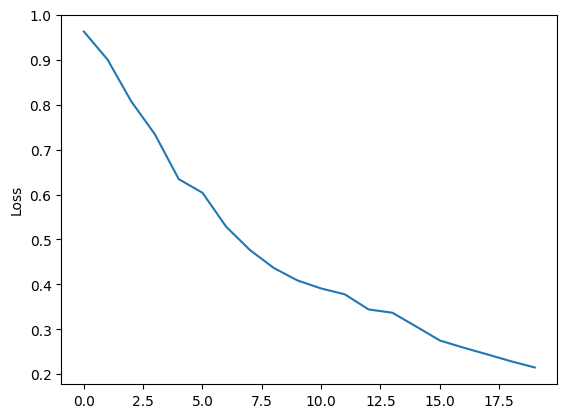

In [104]:
dataset = datasets[2]
X = dataset[0]
y = dataset[1]*2-1 
w = np.ones(len(X)) 



my_stump = My_stump()
my_stump.fit(X, y, w)
my_stump.predict(X)


sk_stump = tree.DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=w)
my_stump = My_stump()
my_stump.fit(X, y, w)

print("Difference in the best threshold:", sk_stump.tree_.threshold[0] -  my_stump.get_threshold())

plot_tree(my_stump,X,y)
plot_tree(sk_stump,X,y)

ab = AdaBoost()


ab.fit(X, y, M = 20)
print(ab.loss_ensemble)
plt.plot(ab.loss_ensemble)
plt.ylabel("Loss")
plt.show()

# Conclusion 

On observe que selon les cas, il est plus ou moins facile d'obtenir des prédictions sans overfitting. Comme dans le cas des lunes : `datasets[1]`. 


Dans le cas de `datasets[0]`, la séparation verticale, les données sont bien séparés avec une perte qui atteint rapidement zéro (environ).


Enfin, dans le `datasets[2]` des points superposés, intrinsèquement, il est diffcile d'obtenir une distinction claire même si l'on obtient un perte inférieure à 20% ce qui est raisonnable selon le cas d'application. (en santé par exemple cela ne serait pas convenable pour viser un cancer)